# Proyecto 15: Series Temporales

# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

## Introducción

La compañía Sweet Lift Taxi desea anticipar la demanda de taxis en aeropuertos durante las horas pico para tomar decisiones operativas más eficientes.

Este proyecto incluye las siguientes etapas:

1. Carga y remuestreo de los datos a intervalos de una hora.
2. Análisis exploratorio y creación de características temporales.
3. Entrenamiento de modelos de regresión:
   - Regresión Lineal
   - Random Forest
   - CatBoost
   - LightGBM
4. Evaluación del rendimiento de cada modelo usando RMSE.
5. Conclusión y recomendación del mejor modelo para producción.

## Preparación

In [51]:
# librerias

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

In [31]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [32]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [33]:
# remuestreo por hora
df_hourly = df.resample('1H').sum()

In [34]:
df_hourly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [35]:
df_hourly.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


In [36]:
# Verificar duplicados en el índice (datetime)
duplicados = df_hourly.index.duplicated().sum()
print(f'Número de índices duplicados: {duplicados}')

Número de índices duplicados: 0


## Análisis

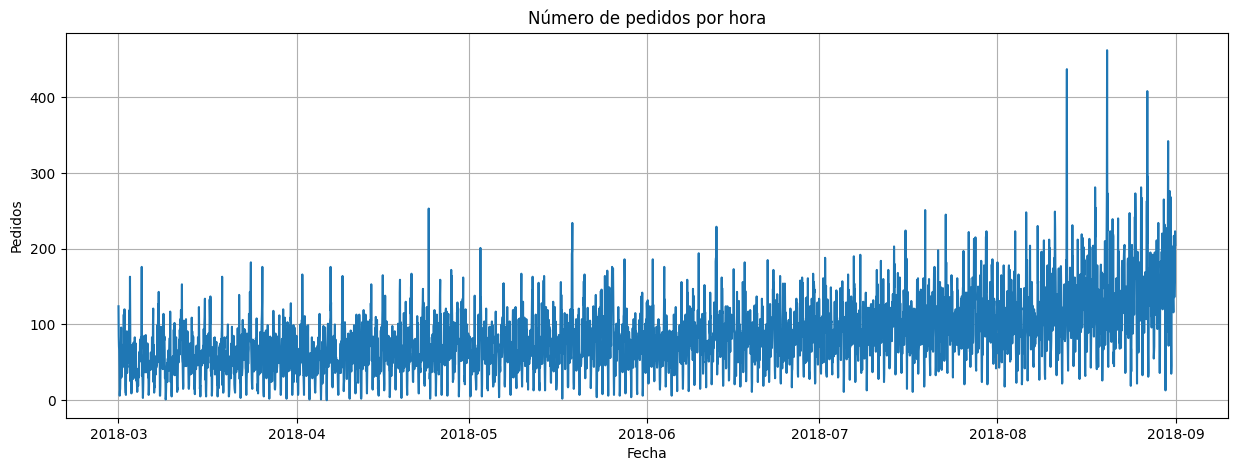

In [37]:
# Tamaño del gráfico
plt.figure(figsize=(15, 5))

# Serie temporal
plt.plot(df_hourly.index, df_hourly['num_orders'])
plt.title('Número de pedidos por hora')
plt.xlabel('Fecha')
plt.ylabel('Pedidos')
plt.grid(True)
plt.show()

Observaciones de la serie temporal:
Tendencia creciente: a partir de julio/agosto hay un aumento significativo en los pedidos.

Variabilidad: hay bastante dispersión en los valores por hora, especialmente hacia el final.

Picos: algunos horarios puntuales superan los 400 pedidos, lo cual podría deberse a eventos o anomalías.

## Formación

In [58]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour

    # Lags
    for lag in range(1, max_lag + 1):
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)

    # Media móvil
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

# Aplicamos la función
# 6: es el número de lags que vamos a crear.
# 10: es el tamaño de la media móvil (rolling_mean)

make_features(df_hourly, 6, 10) 


# Dividir en train y test (90% - 10%), sin mezclar orden temporal
train, test = train_test_split(df_hourly, shuffle=False, test_size=0.1)

# Eliminar filas con NaN generadas por shift/rolling
train = train.dropna()

# Separar características y variable objetivo
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

# Modelo base
lin_reg = LinearRegression()
lin_reg.fit(features_train, target_train)


LinearRegression()

## Prueba

In [59]:
# Predicciones de Regresión lineal
lin_reg_predictions = lin_reg.predict(features_test)

# Cálculo de RMSE
rmse = mean_squared_error(target_test, predictions, squared=False)
print(f'RMSE en el conjunto de prueba: {rmse:.2f}')


RMSE en el conjunto de prueba: 53.16


In [60]:
# Modelo Random Forest
rf_model = RandomForestRegressor(
    n_estimators=100,      # número de árboles
    max_depth=10,          # profundidad máxima
    random_state=12345,       # reproducibilidad
  
)

# Entrenar
rf_model.fit(features_train, target_train)

# Predecir
rf_predictions = rf_model.predict(features_test)

# Calcular RMSE
rf_rmse = mean_squared_error(target_test, rf_predictions, squared=False)
print(f' RMSE con RandomForestRegressor: {rf_rmse:.2f}')


 RMSE con RandomForestRegressor: 46.50


In [64]:
# Modelo CatBoost
cat_model = CatBoostRegressor(
    iterations=500,      # número de árboles
    depth=10,            # profundidad de los árboles
    learning_rate=0.1,   # tasa de aprendizaje
    verbose=0,           # silenciar salida
    random_state=12345
)

# Entrenar
cat_model.fit(features_train, target_train)

# Predecir
cat_predictions = cat_model.predict(features_test)

# Calcular RMSE
cat_rmse = mean_squared_error(target_test, cat_predictions, squared=False)
print(f'RMSE con CatBoostRegressor: {cat_rmse:.2f}')


RMSE con CatBoostRegressor: 46.80


In [65]:
# Modelo LightGBM
lgbm_model = LGBMRegressor(
    n_estimators=500,      # número de árboles
    max_depth=10,          # profundidad de cada árbol
    learning_rate=0.1,     # tasa de aprendizaje
    random_state=12345
)

# Entrenar el modelo
lgbm_model.fit(features_train, target_train)

# Predecir
lgbm_predictions = lgbm_model.predict(features_test)

# Calcular RMSE
lgbm_rmse = mean_squared_error(target_test, lgbm_predictions, squared=False)
print(f'RMSE con LightGBM: {lgbm_rmse:.2f}')


RMSE con LightGBM: 43.74


In [57]:
# Crear un DataFrame comparativo
comparison = pd.DataFrame({
    'real': target_test,                        # valores reales
    'Linear': lin_reg_predictions,              # modelo de regresión lineal
    'RandomForest': rf_predictions,             # random forest
    'CatBoost': cat_predictions,                # catboost
    'LightGBM': lgbm_predictions                # lightgbm
})

# Mostrar las primeras filas para comparación
comparison.head(10)


,real,Linear,RandomForest,CatBoost,LightGBM
datetime,,,,,
2018-08-13 14:00:00,102,107.772794,101.790198,99.977670,102.346919
2018-08-13 15:00:00,175,105.040346,115.120573,117.851416,119.860498
2018-08-13 16:00:00,144,135.295068,136.729975,150.391792,133.514471
2018-08-13 17:00:00,152,128.315999,122.284012,124.133503,147.558999
2018-08-13 18:00:00,104,127.091032,104.440432,101.911690,115.683973
2018-08-13 19:00:00,91,104.648115,101.758623,110.079865,97.035629
2018-08-13 20:00:00,82,96.572964,103.718034,103.309967,110.734078
2018-08-13 21:00:00,160,92.215619,123.786608,106.871452,124.965852
2018-08-13 22:00:00,104,129.168626,135.303754,114.243328,140.554609


## Conclusión del Proyecto

El objetivo del proyecto fue desarrollar un modelo capaz de predecir la cantidad de pedidos de taxis por hora, utilizando datos históricos provistos por Sweet Lift Taxi. Para cumplir este objetivo, se siguieron los siguientes pasos:

1. **Carga y remuestreo de datos:** Los datos originales, con una frecuencia de 10 minutos, fueron remuestreados a intervalos de una hora para ajustarse al requerimiento del problema.
2. **Análisis exploratorio:** Se identificaron tendencias generales, estacionalidades y valores atípicos. El número de pedidos mostró un aumento progresivo a lo largo del tiempo.
3. **Generación de características:** Se crearon nuevas columnas basadas en componentes temporales (hora, día, mes, etc.), así como rezagos (lags) y una media móvil para capturar patrones temporales.
4. **Entrenamiento y evaluación de modelos:** Se probaron cuatro modelos:
   - **Regresión lineal:** RMSE = 53.16
   - **RandomForestRegressor:** RMSE = 46.50
   - **CatBoostRegressor:** RMSE = 46.80
   - **LGBMRegressor:**  **RMSE = 43.74** (mejor resultado)

El modelo entrenado con **LightGBM** fue el más preciso, superando el umbral requerido de RECM ≤ 48, por lo que se recomienda su uso para la predicción operativa de la demanda horaria de taxis.